### Series 5
MohammadAmin Baqeri
<br>
99222018

### JPEG Compression Algorithm

1. Zero padding at the last row and column until they are divisible by block size
2. Subtract each pixel by 128
3. Block division
4. Aplly discrete cosine transform
5. Quantization
6. Zigzag Scanning
7. Truncate till the specified number of coefficient parameters
8. Encode image
9. Zigzag Unscanning
10. Dequantization
11. Aplly inverse discrete cosine transform
12. Add 128 to each pixel

In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List

In [2]:
QUANTIZATION_MATRIX = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ],
    dtype=np.float32,
)

In [3]:
def show_image(image_lst: List[Tuple[cv2.Mat, str]], n_row: int, n_col: int, title: str,
               cmap: str = "viridis", size: tuple = (11, 7)) -> None:

    fig, axes = plt.subplots(n_row, n_col, figsize=size)
    fig.suptitle(title)

    row = 0
    col = 0
    for i in range(len(image_lst)):
        axes[row, col].imshow(image_lst[i][0], cmap=cmap)
        axes[row, col].set_title(image_lst[i][1])
        axes[row, col].axis("off")
        col += 1
        if col == n_col:
            col %= n_col 
            row += 1

In [4]:
def mse(image1: np.ndarray, image2: np.ndarray) -> float:
    return round(np.square(image1 - image2).mean(), 3)

In [5]:
def psnr(image1: np.ndarray, image2: np.ndarray) -> float:
    mse_value = mse(image1, image2)
    if(mse_value == 0):
        return 100
    
    return round(10 * math.log10(255**2 / mse_value), 3) 

In [6]:
def calculate_padding(shape: Tuple[int], block_size: int) -> Tuple[int]:
    h_padded = shape[0] % block_size
    w_padded = shape[1] % block_size
    if h_padded != 0:
        h_padded = shape[0] + block_size - h_padded
    else:
        h_padded = shape[0]

    if w_padded != 0:
        w_padded = shape[1] + block_size - w_padded
    else: 
        w_padded = shape[1]
    
    return h_padded, w_padded

In [7]:
def add_padding(input_array: np.ndarray[np.uint8], shape: Tuple[int], h_padded: int, w_padded: int) -> np.ndarray[np.uint8]:        
    padded_image = np.zeros((h_padded, w_padded), dtype=np.uint8)
    padded_image[:shape[0], :shape[1]] = input_array
    return padded_image

In [8]:
def split(img: np.ndarray[np.float32], shape: Tuple[int], block_size: int) -> List[np.ndarray[np.float32]]:
    """Split one-channel image into blocks"""
    
    blocks = [
        img[h : h + block_size, w : w + block_size]
        for h in range(0, shape[0], block_size)
        for w in range(0, shape[1], block_size)
    ]
    return blocks

In [9]:
def dct_transform(img_lst: List[np.ndarray[np.float32]]) -> List[np.ndarray[np.float32]]:
    """Apply discrete cosine transform to an image"""
    
    for i in range(len(img_lst)):
        img_lst[i] = cv2.dct(img_lst[i])
    return img_lst

In [10]:
def zigzag_scan(block: np.ndarray[np.int32]) -> np.ndarray[np.int32]:
    """Scans a block in zigzag order"""
    
    block_size = block.shape[0]
    zigzag_arr = np.concatenate(
        [
            np.diagonal(block[::-1, :], i)[:: (2 * (i % 2) - 1)]
            for i in range(1 - block_size, block_size)
        ]
    )
    return zigzag_arr

In [11]:
def zigzag_unscan(zigzag_arr: np.ndarray[np.int32], block_size: int) -> np.ndarray[np.float32]:
    """Unscans a 1D array in zigzag order"""
    
    block = np.zeros((block_size, block_size), dtype=np.float32)
    x, y = 0, 0
    for num in zigzag_arr:
        block[x, y] = num
        if (x + y) % 2 == 0:
            if y == block_size - 1:
                x += 1
            elif x == 0:
                y += 1
            else:
                x -= 1
                y += 1
        else:
            if x == block_size - 1:
                y += 1
            elif y == 0:
                x += 1
            else:
                x += 1
                y -= 1

    return block

In [12]:
def seperate_channels(image: cv2.Mat) -> List[np.ndarray[np.uint8]]:
    output_channels = None
    if len(image.shape) == 3:
        output_channels = cv2.split(image)
    else:
        output_channels = [image]
    return output_channels

In [13]:
def preprocess(image: cv2.Mat, block_size: int) -> List[np.ndarray[np.uint8]]:
    output_channels = []
    channels = seperate_channels(image)
    for i in range(len(channels)):
        shape = channels[i].shape
        h_padded, w_padded = calculate_padding(shape, block_size)
        output_channels.append(add_padding(channels[i], shape, h_padded, w_padded).astype(np.float32) - 128)
    return output_channels

In [14]:
def jpeg_encode(image: np.ndarray[np.float32], block_size: int, num_coefficients: int) -> List[np.ndarray[np.int32]]:
    """Encode an image to JEPG"""
    
    blocks = split(image, image.shape, block_size)
    blocks = dct_transform(blocks)

    resized_quantization_matrix = cv2.resize(QUANTIZATION_MATRIX, (block_size, block_size), cv2.INTER_CUBIC)
    quantized_blocks = [np.round(block / resized_quantization_matrix).astype(np.int32) for block in blocks]
    zigzag_scanned_blocks = [zigzag_scan(block) for block in quantized_blocks]

    return [block[:num_coefficients] for block in zigzag_scanned_blocks]


In [15]:
def jpeg_decoode(encoded_channels: List[np.ndarray[np.int32]], image: np.ndarray[np.uint8], block_size: int) -> np.ndarray[np.uint8]:
    """Decode JEPG encoded image"""
    
    decode_channels = []
    shape = image.shape
    resized_quantization_matrix = cv2.resize(
        QUANTIZATION_MATRIX, (block_size, block_size), cv2.INTER_CUBIC
    )
    h_padded, w_padded = calculate_padding(shape, block_size)
    for channel in encoded_channels:
        zigzag_unscanned_blocks = [zigzag_unscan(block, block_size) for block in channel]
        dequantized_blocks = [
            block * resized_quantization_matrix for block in zigzag_unscanned_blocks
        ]
        idct_blocks = [cv2.idct(block) for block in dequantized_blocks]
        compressed_channel = np.zeros((h_padded, w_padded), dtype=np.float32)

        block_index = 0
        for i in range(0, h_padded, block_size):
            for j in range(0, w_padded, block_size):
                compressed_channel[i : i + block_size, j : j + block_size] = idct_blocks[
                    block_index
                ]
                block_index += 1

        compressed_channel += 128
        compressed_channel = np.clip(compressed_channel, 0, 255)
        decode_channels.append(compressed_channel[:shape[0], :shape[1]].astype(np.uint8))
    
    return decode_channels

In [16]:
def compress(image: cv2.Mat, block_size: int, num_coefficients: int) -> List[int]:
    """Compress an image with JPEG method"""    
    
    compressed_image = None
    encoded_channels = []
    channels = preprocess(image, block_size)
    
    for channel in channels:
        encoded_channels.append(jpeg_encode(channel, block_size, num_coefficients))

    compressed_image = jpeg_decoode(encoded_channels, image, block_size)
    return cv2.merge(compressed_image)

In [17]:
def save(image: cv2.Mat, directory_path: str, file_name: str) -> None:
    if not os.path.exists(directory_path):
        os.makedirs(directory_path, exist_ok=True)
    
    cv2.imwrite(os.path.join(directory_path, file_name), image)

In [18]:
image1 = cv2.cvtColor(cv2.imread("files/series5/img1.jpg"), cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(cv2.imread("files/series5/img2.jpg"), cv2.COLOR_BGR2RGB)
df = pd.DataFrame(columns=["Name", "Block_size", "Coefficients", "MSE", "PSNR", "Size", "Original_size"])

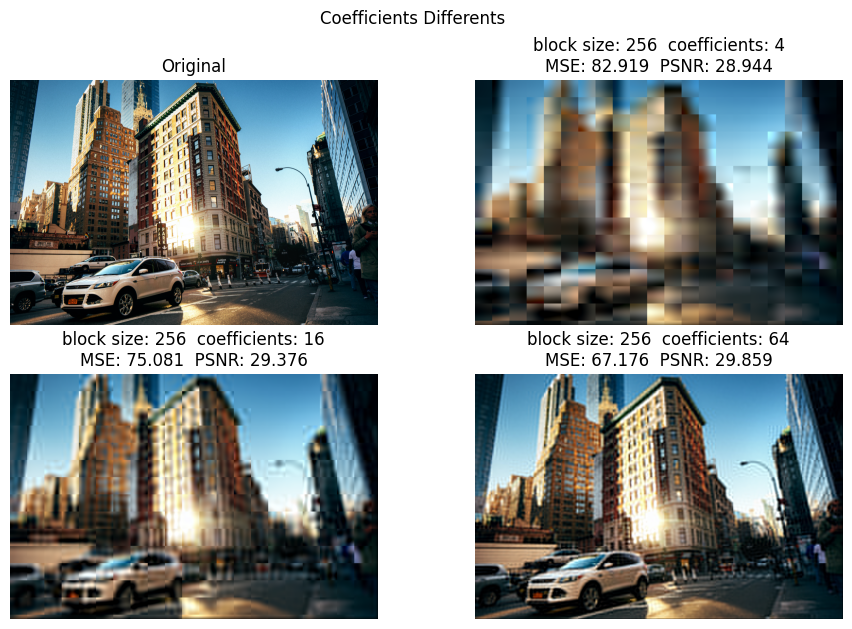

In [19]:
output_lst = [(image1, "Original")]
original_size = round(os.path.getsize("files/series5/img1.jpg") / 1024, 2)
block_size = 256
for i in range(1, 4):
    coefficients = 4**i
    compressed = compress(image1, block_size, coefficients)
    mse_value = mse(image1, compressed)
    psnr_value = psnr(image1, compressed)
    output_lst.append((compressed, f"block size: {block_size}  coefficients: {coefficients}\n" +
                       f"MSE: {mse_value}  PSNR: {psnr_value}"))
    save(cv2.cvtColor(compressed, cv2.COLOR_RGB2BGR), "files/series5/compressed", f"1_b{block_size}_c{coefficients}.jpeg")
    file_size = round(os.path.getsize(f"files/series5/compressed/1_b{block_size}_c{coefficients}.jpeg") / 1024, 2)
    df.loc[len(df)] = {"Name": f"1_b{block_size}_c{coefficients}.jpeg", "Block_size": block_size,
               "Coefficients": coefficients, "MSE": mse_value, "PSNR": psnr_value,
               "Size": file_size,"Original_size": original_size}
show_image(output_lst, 2, 2, "Coefficients Differents")

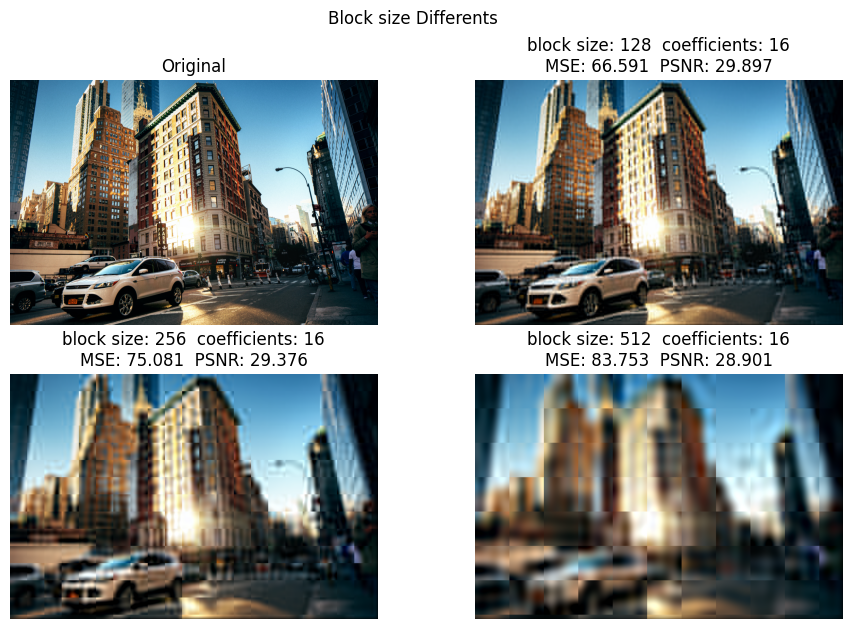

In [20]:
output_lst = [(image1, "Original")]
for i in range(1, 4):
    coefficients = 16
    block_size = 2**(i+6)
    compressed = compress(image1, block_size, coefficients)
    mse_value = mse(image1, compressed)
    psnr_value = psnr(image1, compressed)
    output_lst.append((compressed, f"block size: {block_size}  coefficients: {coefficients}\n" +
                       f"MSE: {mse_value}  PSNR: {psnr_value}"))
    save(cv2.cvtColor(compressed, cv2.COLOR_RGB2BGR), "files/series5/compressed", f"1_b{block_size}_c{coefficients}.jpeg")
    file_size = round(os.path.getsize(f"files/series5/compressed/1_b{block_size}_c{coefficients}.jpeg") / 1024, 2)
    df.loc[len(df)] = {"Name": f"1_b{block_size}_c{coefficients}.jpeg", "Block_size": block_size,
                        "Coefficients": {coefficients}, "MSE": mse_value, "PSNR": psnr_value,
                        "Size": file_size,"Original_size": original_size}

show_image(output_lst, 2, 2, "Block size Differents")

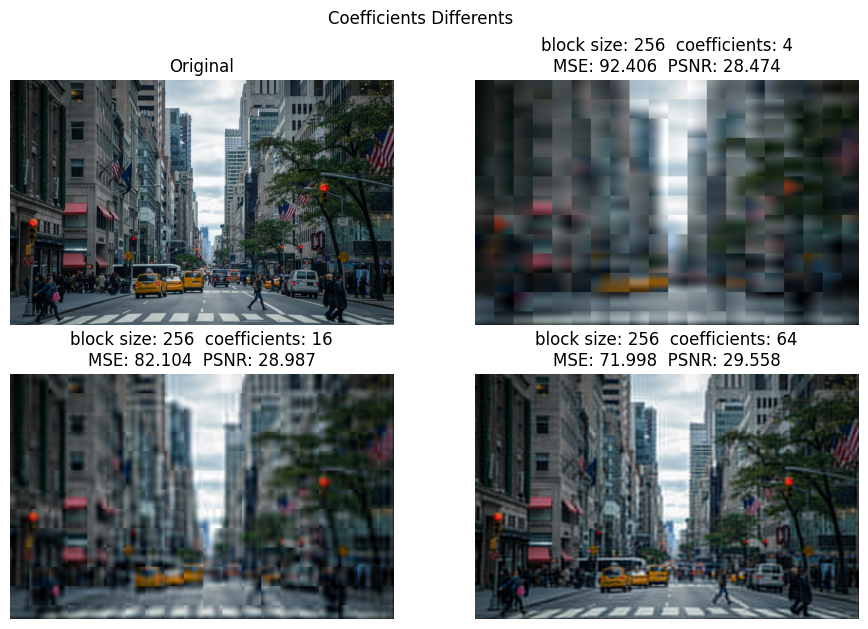

In [21]:
output_lst = [(image2, "Original")]
original_size = round(os.path.getsize("files/series5/img2.jpg") / 1024, 2)
block_size = 256
for i in range(1, 4):
    coefficients = 4**i
    compressed = compress(image2, block_size, coefficients)
    mse_value = mse(image2, compressed)
    psnr_value = psnr(image2, compressed)
    output_lst.append((compressed, f"block size: {block_size}  coefficients: {coefficients}\n" +
                       f"MSE: {mse_value}  PSNR: {psnr_value}"))
    save(cv2.cvtColor(compressed, cv2.COLOR_RGB2BGR), "files/series5/compressed", f"2_b{block_size}_c{coefficients}.jpeg")
    file_size = round(os.path.getsize(f"files/series5/compressed/2_b{block_size}_c{coefficients}.jpeg") / 1024, 2)
    df.loc[len(df)] = {"Name": f"2_b{block_size}_c{coefficients}.jpeg", "Block_size": block_size,
               "Coefficients": coefficients, "MSE": mse_value, "PSNR": psnr_value,
               "Size": file_size,"Original_size": original_size}
show_image(output_lst, 2, 2, "Coefficients Differents")

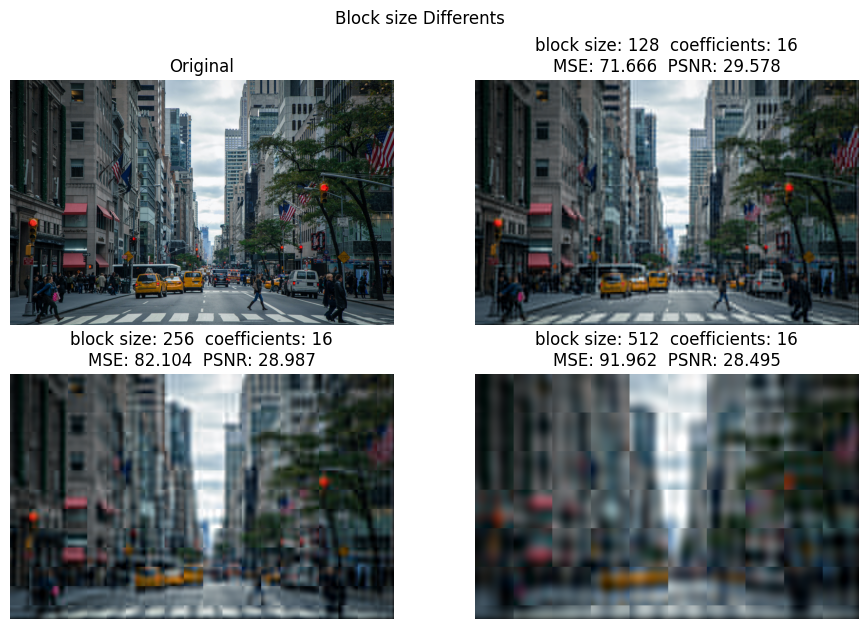

In [22]:
output_lst = [(image2, "Original")]
for i in range(1, 4):
    coefficients = 16
    block_size = 2**(i+6)
    compressed = compress(image2, block_size, coefficients)
    mse_value = mse(image2, compressed)
    psnr_value = psnr(image2, compressed)
    output_lst.append((compressed, f"block size: {block_size}  coefficients: {coefficients}\n" +
                       f"MSE: {mse_value}  PSNR: {psnr_value}"))
    save(cv2.cvtColor(compressed, cv2.COLOR_RGB2BGR), "files/series5/compressed", f"2_b{block_size}_c{coefficients}.jpeg")
    file_size = round(os.path.getsize(f"files/series5/compressed/2_b{block_size}_c{coefficients}.jpeg") / 1024, 2)
    df.loc[len(df)] = {"Name": f"2_b{block_size}_c{coefficients}.jpeg", "Block_size": block_size,
                       "Coefficients": {coefficients}, "MSE": mse_value, "PSNR": psnr_value,
                       "Size": file_size,"Original_size": original_size}
show_image(output_lst, 2, 2, "Block size Differents")

In [23]:
df.style

,Name,Block_size,Coefficients,MSE,PSNR,Size,Original_size
0,1_b256_c4.jpeg,256,4,82.919000,28.944000,1203.310000,3988.610000
1,1_b256_c16.jpeg,256,16,75.081000,29.376000,1579.290000,3988.610000
2,1_b256_c64.jpeg,256,64,67.176000,29.859000,2066.410000,3988.610000
3,1_b128_c16.jpeg,128,{16},66.591000,29.897000,1971.480000,3988.610000
4,1_b256_c16.jpeg,256,{16},75.081000,29.376000,1579.290000,3988.610000
5,1_b512_c16.jpeg,512,{16},83.753000,28.901000,1338.670000,3988.610000
6,2_b256_c4.jpeg,256,4,92.406000,28.474000,943.170000,3151.870000
7,2_b256_c16.jpeg,256,16,82.104000,28.987000,1251.390000,3151.870000
8,2_b256_c64.jpeg,256,64,71.998000,29.558000,1634.450000,3151.870000
9,2_b128_c16.jpeg,128,{16},71.666000,29.578000,1573.140000,3151.870000


<Axes: xlabel='Coefficients', ylabel='PSNR'>

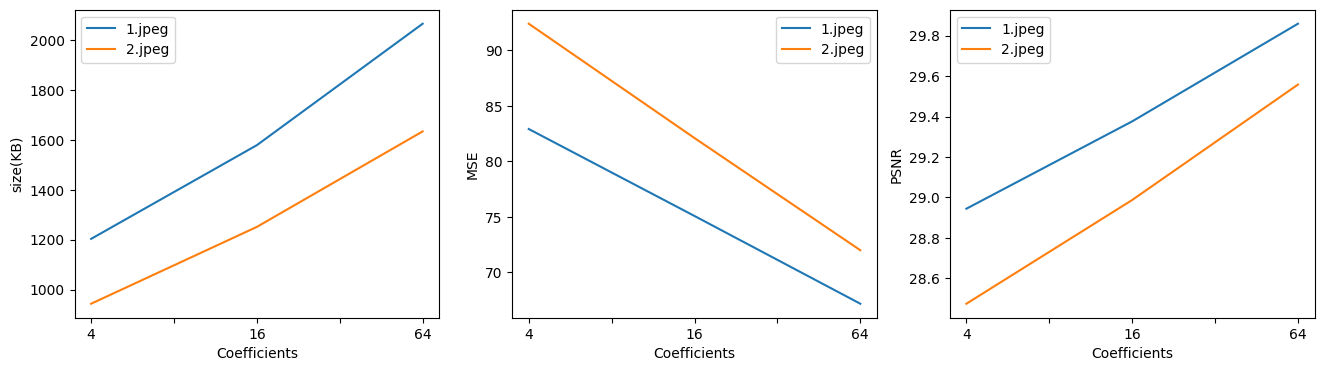

In [24]:
temp_df1 = df.iloc[[0, 1, 2]]
temp_df2 = df.iloc[[6, 7, 8]]
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

temp_df1.plot(ax=axes[0], x='Coefficients', y='Size', label="1.jpeg", ylabel="size(KB)")
temp_df2.plot(ax=axes[0], x='Coefficients', y='Size', label="2.jpeg", ylabel="size(KB)")
temp_df1.plot(ax=axes[1], x='Coefficients', y='MSE', label="1.jpeg", ylabel="MSE")
temp_df2.plot(ax=axes[1], x='Coefficients', y='MSE', label="2.jpeg", ylabel="MSE")
temp_df1.plot(ax=axes[2], x='Coefficients', y='PSNR', label="1.jpeg", ylabel="PSNR")
temp_df2.plot(ax=axes[2], x='Coefficients', y='PSNR', label="2.jpeg", ylabel="PSNR")

We can see that:
<br>
as the value of coefficient increases, the size of the image and its quality increase, the value of MSE decreases but PSNR a little increases

<Axes: xlabel='Block_size', ylabel='PSNR'>

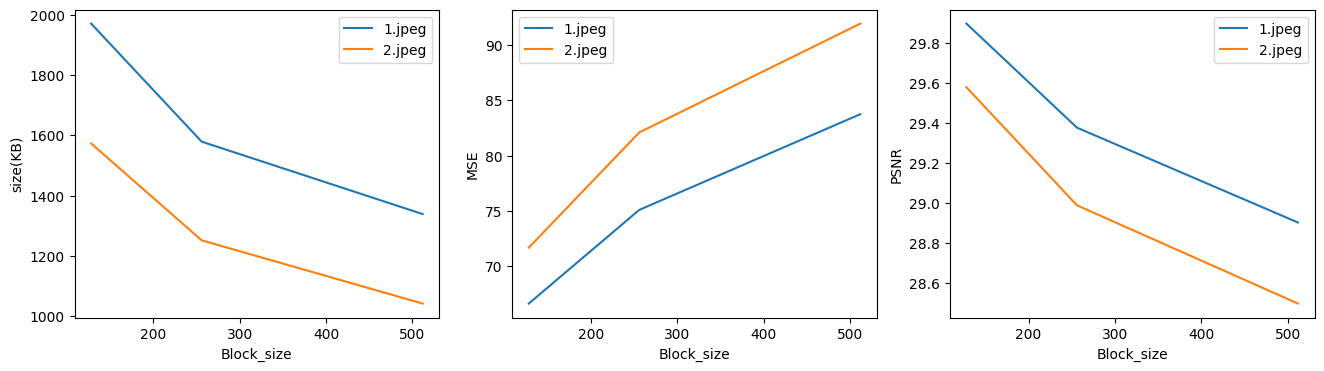

In [25]:
temp_df1 = df.iloc[[3, 4, 5]]
temp_df2 = df.iloc[[9, 10, 11]]
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

temp_df1.plot(ax=axes[0], x='Block_size', y='Size', label="1.jpeg", ylabel="size(KB)")
temp_df2.plot(ax=axes[0], x='Block_size', y='Size', label="2.jpeg", ylabel="size(KB)")
temp_df1.plot(ax=axes[1], x='Block_size', y='MSE', label="1.jpeg", ylabel="MSE")
temp_df2.plot(ax=axes[1], x='Block_size', y='MSE', label="2.jpeg", ylabel="MSE")
temp_df1.plot(ax=axes[2], x='Block_size', y='PSNR', label="1.jpeg", ylabel="PSNR")
temp_df2.plot(ax=axes[2], x='Block_size', y='PSNR', label="2.jpeg", ylabel="PSNR")

As the block size increases, the size of the image and its quality decrease, the value of MSE increases but PSNR a little decreases